In [181]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import math
import cv2
import os

# UTILS

In [155]:
def features_labels(file, scale=True):
    dataset = torch.load(file)
    features = np.asarray(dataset['features'])
    if scale is True:
        features = (features - np.mean(features, axis=0)) / (np.std(features, axis=0) + 1e-9)
    labels = np.asarray(dataset['labels'])
    return features, labels


def name_features(n_features=68):
    stat = ['MEAN', 'STD', 'MAX', 'MIN']
    hist = ['BIN_' + str(i) for i in range(4)]
    glcm = []
    for prop in ['CON', 'HOM', 'ENG', 'COR', 'ENT']:
        for d in [1, 2, 4]:
            for th in ['0', 'Pi/4', 'Pi/2', '3Pi/4']:
                glcm += [prop + '_' + str(d) + '_' + th]
    return np.concatenate([stat, hist, glcm])


def delete_noise(features, labels, std):
    ''' DELETE SAMPLES WITH NOISE DATA (FEACH VAL != [std, +std]) '''
    ind = np.where((features < -1 * std) | (features > std))[0]
    features = np.delete(features, ind, axis=0)
    labels = np.delete(labels, ind)
    return features, labels


def load_features(file, a, b, std=3, scale=True, is_print=True):
    ''' Загрузка и стандартизация '''
    features, labels = features_labels(file, scale=scale)
    n_features = len(features[0])
    before = len(features)
    features = features[:, a:b]
    if is_print:
        print(f'SRC features shape: {features.shape}')
    
    '''Удаление шумов в 3std'''
    features, labels = delete_noise(features, labels, std)
    if is_print:
        print(f'Shape after delete noise: {features.shape}')
    
    delta = int((1-features.shape[0]/before)*1000)/10.
    labels = list(labels)
    delta_per_class = [int((labels.count(i)/844*1000)/10) for i in range(6)]
    if is_print:
        print(f'{delta}% дальше, чем {std}std')
        print(f'{delta_per_class} % по классам')
    return features, labels

In [159]:
def plot(a, b, mode, std=3, scale=True, xticklabels=['-3σ', '-2σ', '-σ', '0', 'σ', '2σ', '3σ']):
    file = os.path.join(os.getcwd(), f'..\\data\\{mode}\\train\\R.pth') 
    features, labels = load_features(file, a, b, std, scale)
    
    '''Приведение в диапазон [0, 1] и визуализация'''
    features = (features + std) / (2*std)
    classes = ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Septoria_leaf_spot', 'Yellow_Leaf_Curl_Virus']
    data = [[classes[l]] + list(f) for l, f in zip(labels, features)]
    df = pd.DataFrame.from_dict(data)
    names = np.concatenate([['Класс'], name_features(68)[a:b]])
    df.columns = names
    
    std = math.ceil(std)
    xlim = (-std, std)
    bins = list(range(-std, std+1))
    mean = 0.5
    std = 1. / 6.
    loc = np.full((len(bins),), mean) + np.asarray(bins) * std
    
    plt.figure(dpi=300)
    sns.set_context('paper')
    hue_order =['Bacterial_spot', 'Healthy', 'Yellow_Leaf_Curl_Virus', 'Late_blight', 'Septoria_leaf_spot', 'Early_blight']
    g = sns.pairplot(data=df, vars=df.columns[1:], hue="Класс", hue_order=hue_order,
                     plot_kws=dict(marker=".", linewidth=0, s=25)) 
    g.set(xticks=loc, xticklabels=xticklabels, xlim=(mean + std * (np.min(bins)-1), mean + std * (np.max(bins)+1)))
    plt.subplots_adjust(hspace=0.1, wspace=0.15)
    plt.show()
    
    '''Detect plot'''
    classes = ['Больные', 'Больные', 'Здоровые', 'Больные', 'Больные', 'Больные'] 
    data = [[classes[l]] + list(f) for l, f in zip(labels, features)]
    df = pd.DataFrame.from_dict(data)
    names = np.concatenate([['Класс'], name_features(68)[a:b]])
    df.columns = names
    hue_order = ['Больные', 'Здоровые']
    g = sns.pairplot(data=df, vars=df.columns[1:], hue="Класс", hue_order=hue_order,
                     plot_kws=dict(marker=".", linewidth=0, s=25)) 
    g.set(xticks=loc, xticklabels=xticklabels, xlim=(mean + std * (np.min(bins)-1), mean + std * (np.max(bins)+1)))
    plt.subplots_adjust(hspace=0.1, wspace=0.15)
    plt.show()

In [157]:
def LDA(a, b, mode, task='clas', std=3, scale=True): 
    file = os.path.join(os.getcwd(), f'..\\data\\{mode}\\train\\R.pth') 
    features, labels = load_features(file, a, b, std, scale, False)
    clf = LinearDiscriminantAnalysis(n_components=1)
    features=clf.fit_transform(features, labels)
    
    bins = np.arange(-std, std+1)
    loc = np.full((len(bins),), 0.5) + bins / (2 * std)
    features = (features + std) / (2 * std)
    xlim = (0.5 + 1/6 * (np.min(bins)-1), 0.5 + 1/6 * (np.max(bins)+1))
    
    
    classes = ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Septoria', 'Yellow_Virus'] \
                    if task == 'class' else ['Больные', 'Больные', 'Здоровые', 'Больные', 'Больные', 'Больные']
    data = [[classes[l]] + list(f) for l, f in zip(labels, features)]
    df = pd.DataFrame.from_dict(data)
    names = np.concatenate([['Класс'], list(range(len(features[0])))])
    df.columns = names

    sns.set_context("talk", font_scale=1.1)
    hue_order =['Bacterial_spot', 'Healthy', 'Yellow_Virus', 'Late_blight', 'Septoria', 'Early_blight'] \
                 if task == 'class' else ['Больные', 'Здоровые']
    g = sns.kdeplot(data=df, x='0', hue="Класс", hue_order=hue_order, fill=True) 

    old_legend = g.legend_
    handles = old_legend.legendHandles
    legend_labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    g.legend(handles, legend_labels, loc='center', bbox_to_anchor= (1.35, 0.5), title=title)
    
    xticklabels=['-3σ', '-2σ', '-σ', '0', 'σ', '2σ', '3σ']
    g.set(xticks=loc, xticklabels=xticklabels, xlim=xlim)

    plt.xlabel('')
    plt.ylabel('Вероятность')
    plt.title(f'LDA {task}')
    plt.show()
    plt.clf()

# STAT

## Nonzero Global

SRC features shape: (5064, 4)
Shape after delete noise: (4903, 4)
3.1% дальше, чем 3std
[90, 99, 100, 97, 93, 100] % по классам


<Figure size 1800x1200 with 0 Axes>

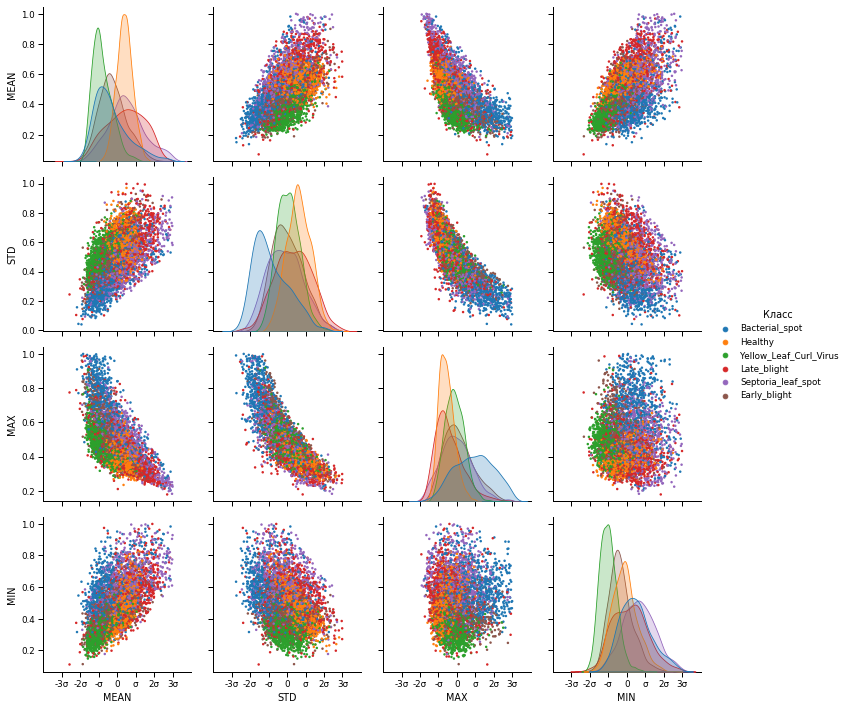

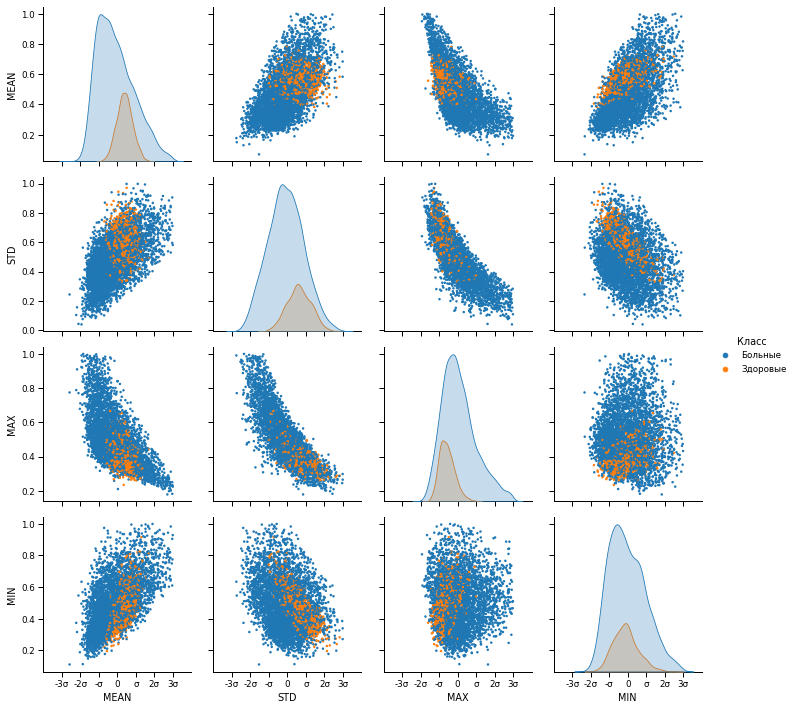

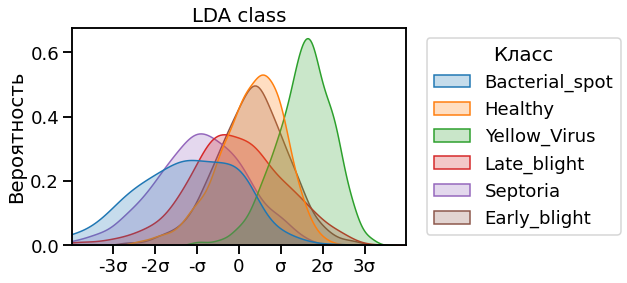

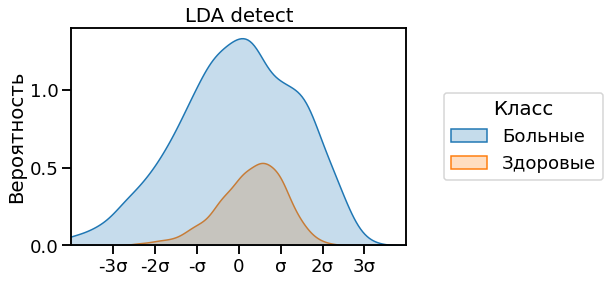

<Figure size 432x288 with 0 Axes>

In [160]:
plot(0, 4, 'global')
LDA(0, 4, 'global', 'class')
LDA(0, 4, 'global', 'detect')

## Nonzero Local

SRC features shape: (5064, 4)
Shape after delete noise: (5001, 4)
1.2% дальше, чем 3std
[97, 99, 100, 98, 96, 99] % по классам


<Figure size 1800x1200 with 0 Axes>

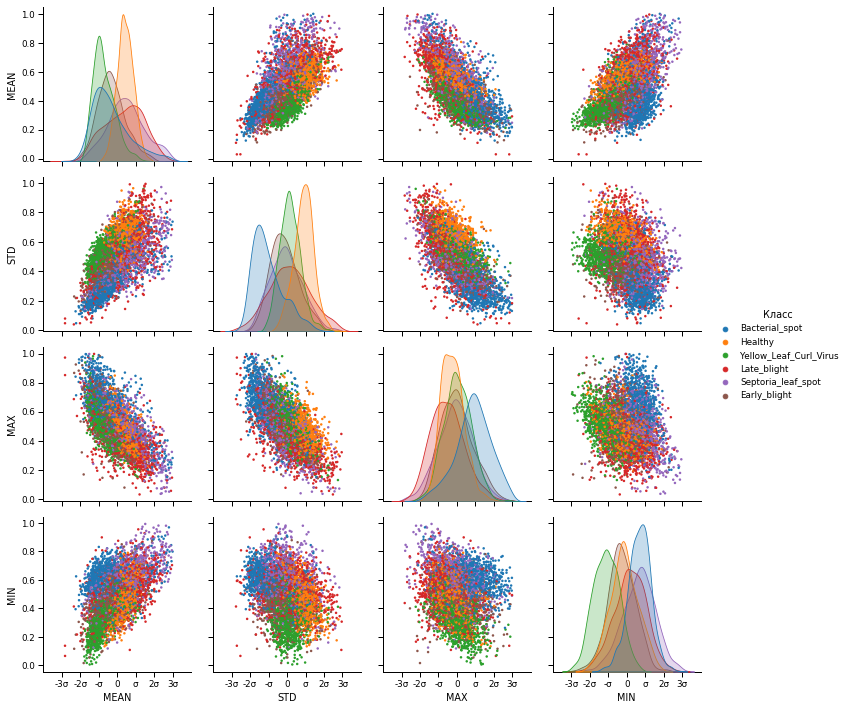

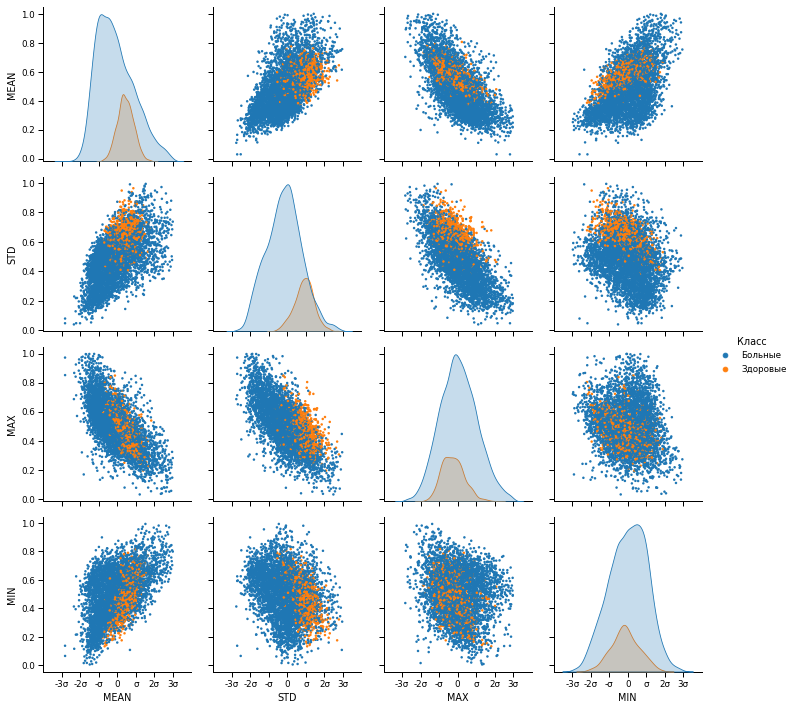

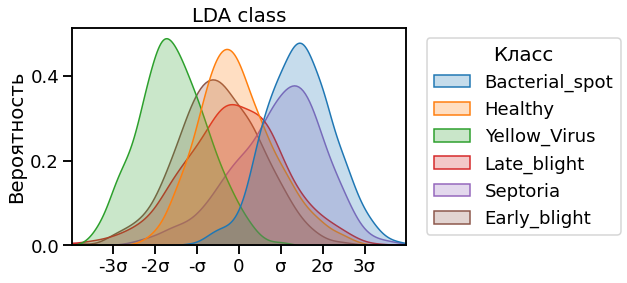

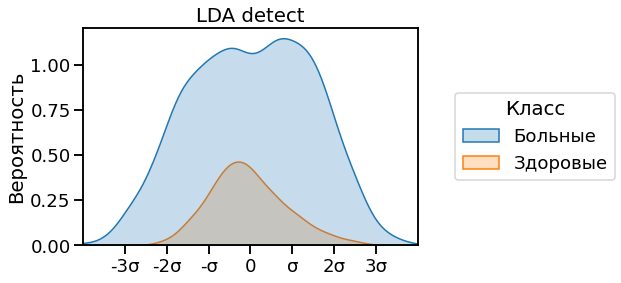

<Figure size 432x288 with 0 Axes>

In [161]:
plot(0, 4, 'local')Вид 
LDA(0, 4, 'local', 'class')
LDA(0, 4, 'local', 'detect')

# HIST

# Гистограммы для каждого класса


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:28<00:00,  4.67s/it]


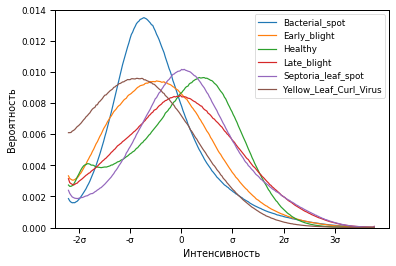

In [185]:
def group_flatten(root, delta):
    files = os.listdir(root)
    data = []
    for file in files:
        img = cv2.imread(os.path.join(root, file))
        img = img[:, :, 2]
        img = img[img > delta]
        data += list(img.flatten())
    return data

def plot_hist(root, delta=5, mean=100.8, std=40.6):
    dirs = os.listdir(root)
    bins = np.arange(11, 256)
    sns.set_context('paper')
    for k in tqdm(dirs):
        data = group_flatten(os.path.join(root, k), delta)
        hist = np.histogram(data, bins, density=True)[0]
        plt.plot(np.arange(11, 11 + len(hist)), hist, label=k)

    xticklabels = ['-3σ', '-2σ', '-σ', '0', 'σ', '2σ', '3σ']
    bins = list(range(-3, 4))
    loc = np.full((len(bins),), mean) + np.asarray(bins) * std
    plt.xticks(loc, xticklabels)

    _, r = plt.xlim()
    plt.xlim(0, r)
    plt.ylim(0, 0.014)
    plt.xlabel('Интенсивность')
    plt.ylabel('Вероятность')
    plt.legend()

plot_hist(os.path.join(os.getcwd(), '..//ds'))

# Nonzero Global

SRC features shape: (5064, 4)
Shape after delete noise: (4860, 4)
4.0% дальше, чем 3std
[89, 97, 99, 96, 93, 99] % по классам


<Figure size 1800x1200 with 0 Axes>

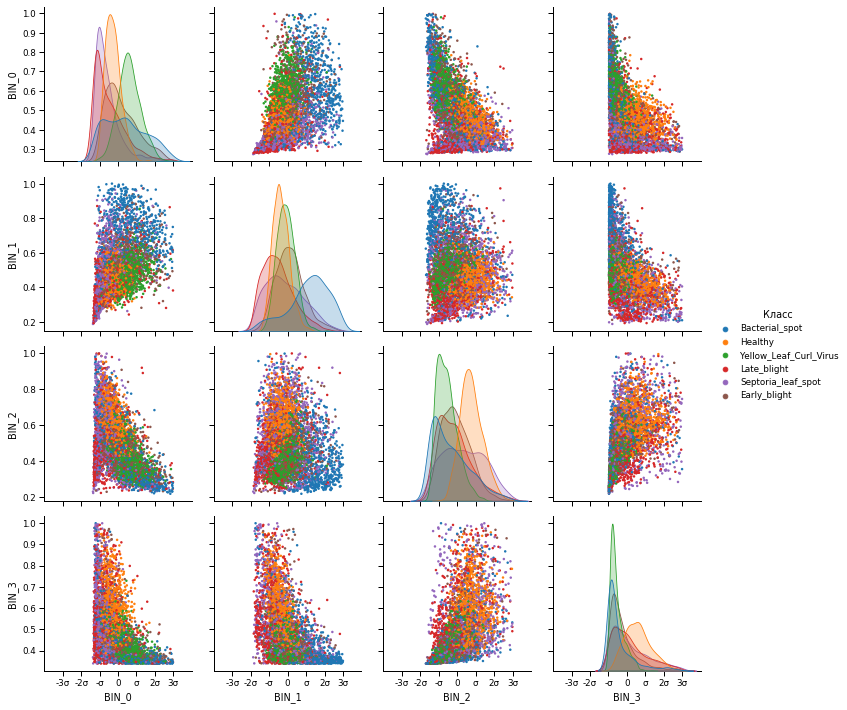

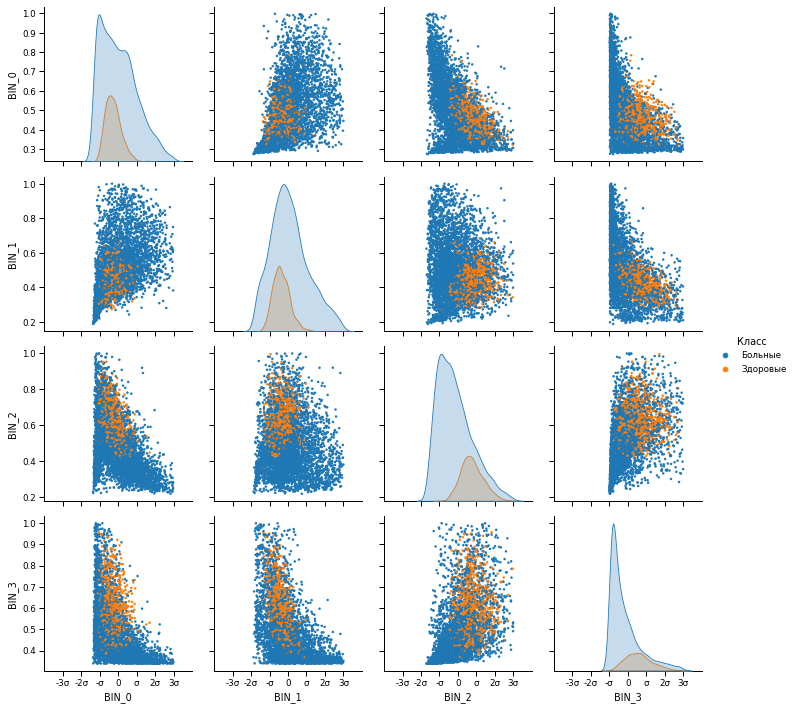

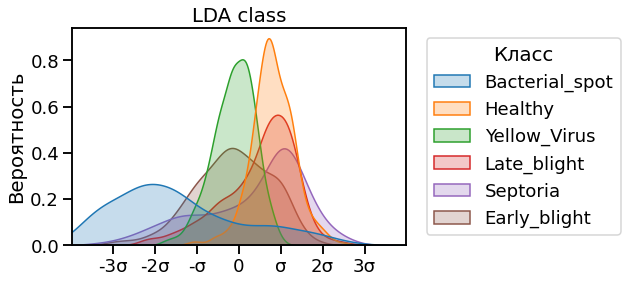

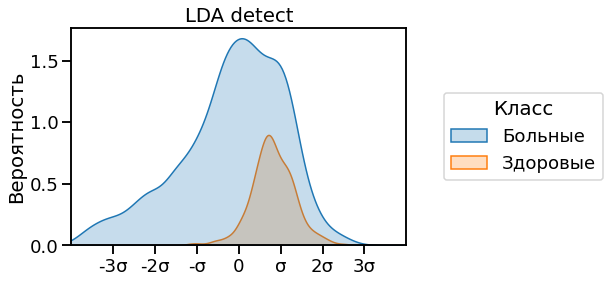

<Figure size 432x288 with 0 Axes>

In [170]:
plot(4, 8, 'global')
LDA(4, 8, 'global', 'class')
LDA(4, 8, 'global', 'detect')

# file = os.path.join(os.getcwd(), '..\\data\\global\\train\\R_stat_hist_double_hist.pth') 
# plot(file, 4, 12, 'global')

# Nonzero Local

SRC features shape: (5064, 4)
Shape after delete noise: (4924, 4)
2.7% дальше, чем 3std
[92, 98, 100, 97, 94, 100] % по классам


<Figure size 1800x1200 with 0 Axes>

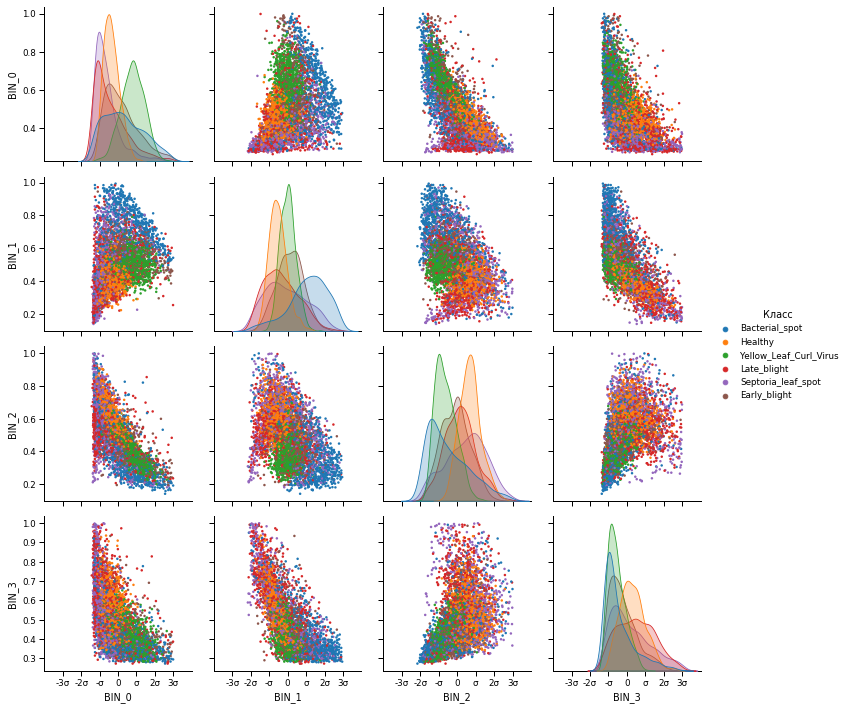

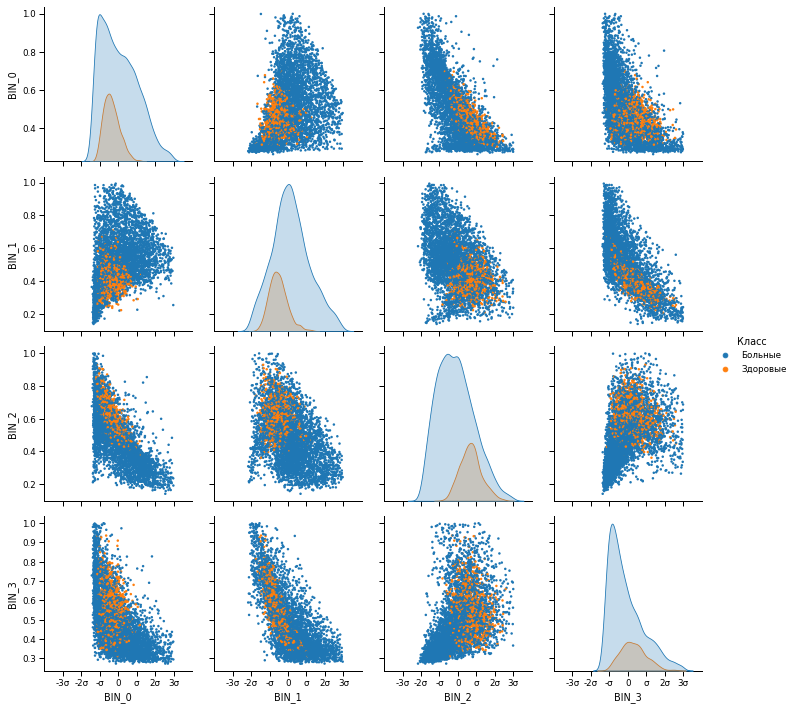

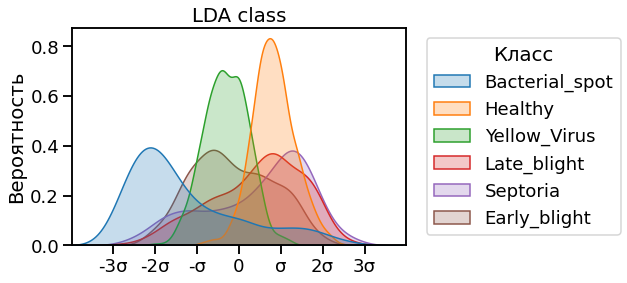

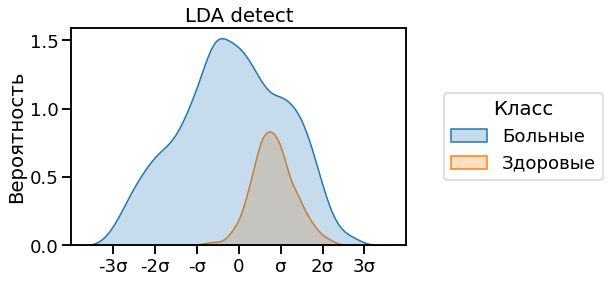

<Figure size 432x288 with 0 Axes>

In [171]:
plot(4, 8, 'local')
LDA(4, 8, 'local', 'class')
LDA(4, 8, 'local', 'detect')